/var/folders/bn/67qzjvps6cz42p_ym850l74r0000gn/T/ipykernel_39225/1318256873.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_data['period_end'] = pd.to_datetime(wind_data['period_end'])


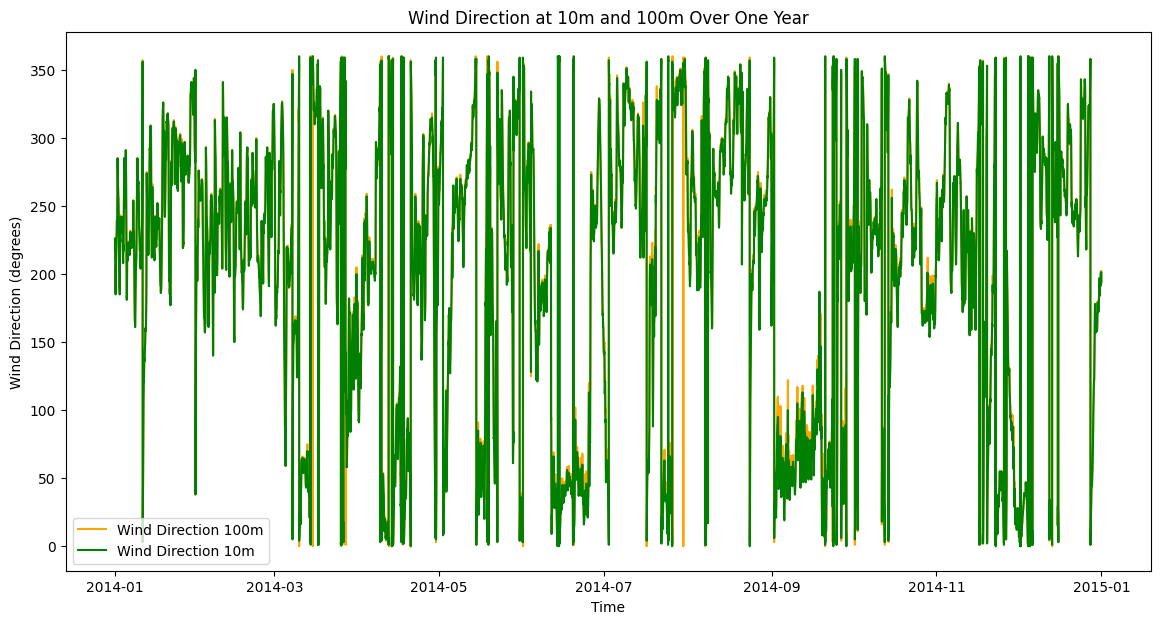

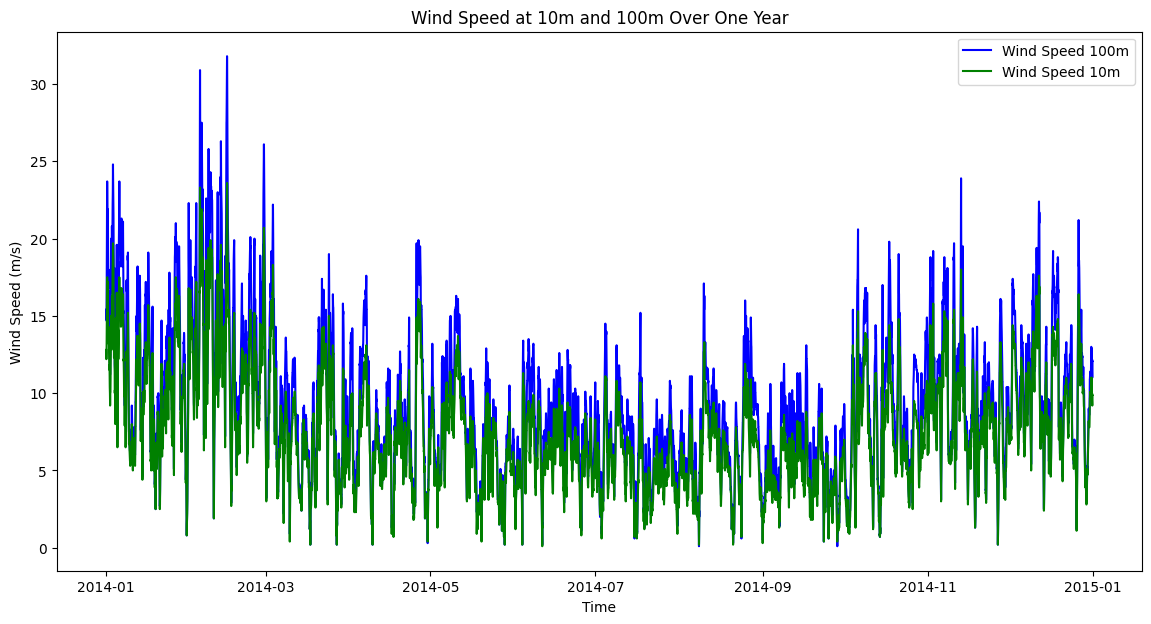

Number of hours during which the wind was not blowing: 0


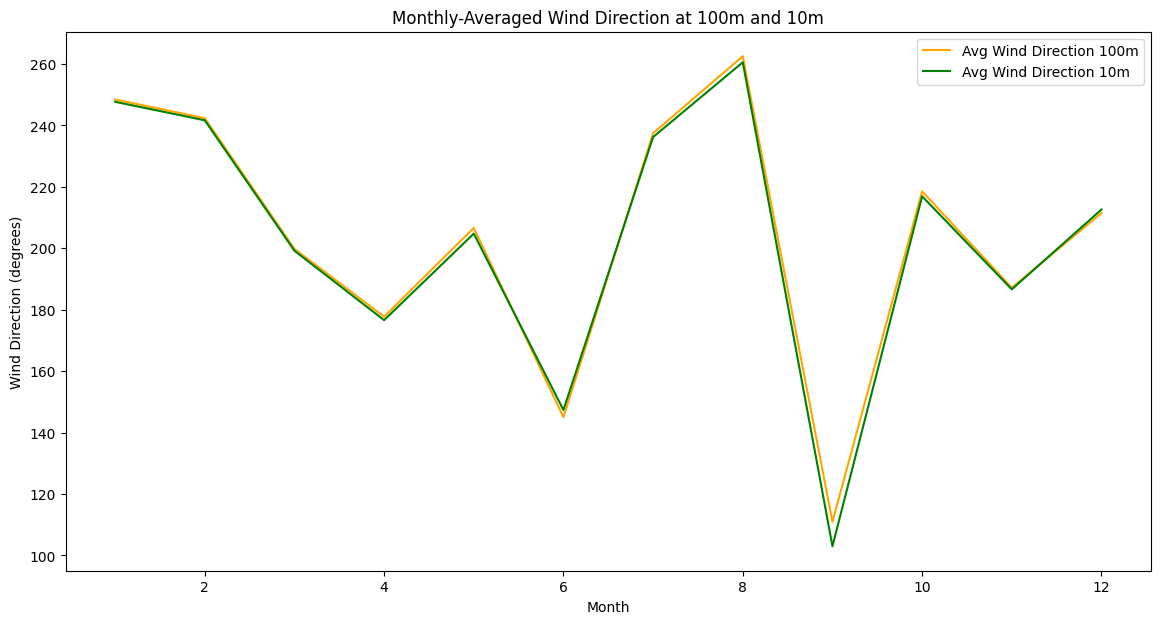

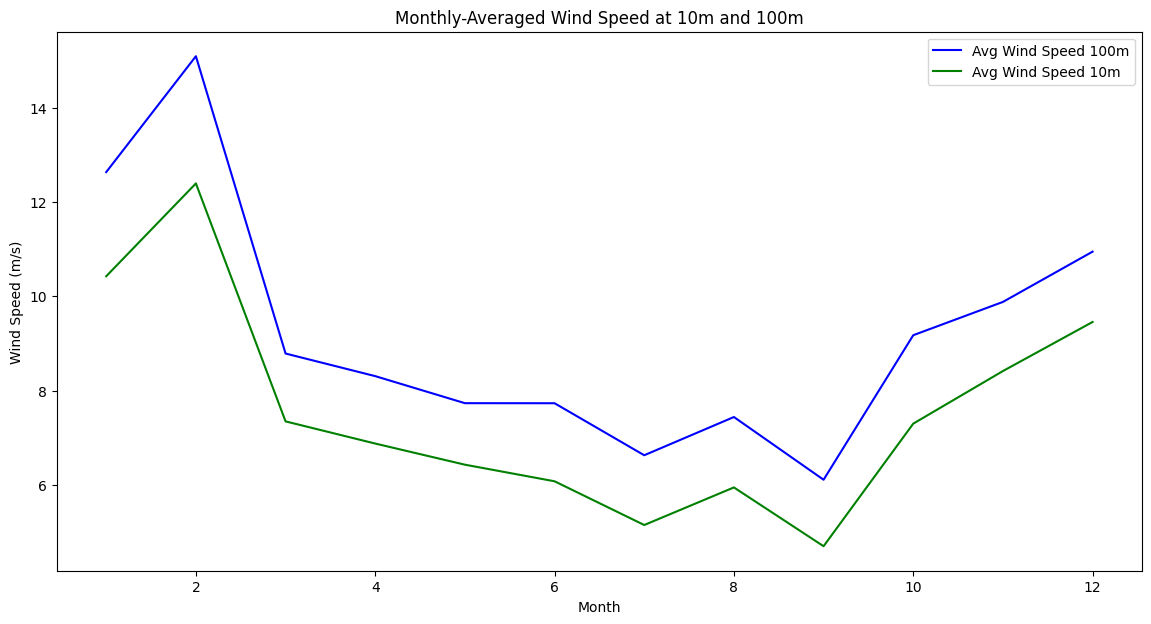

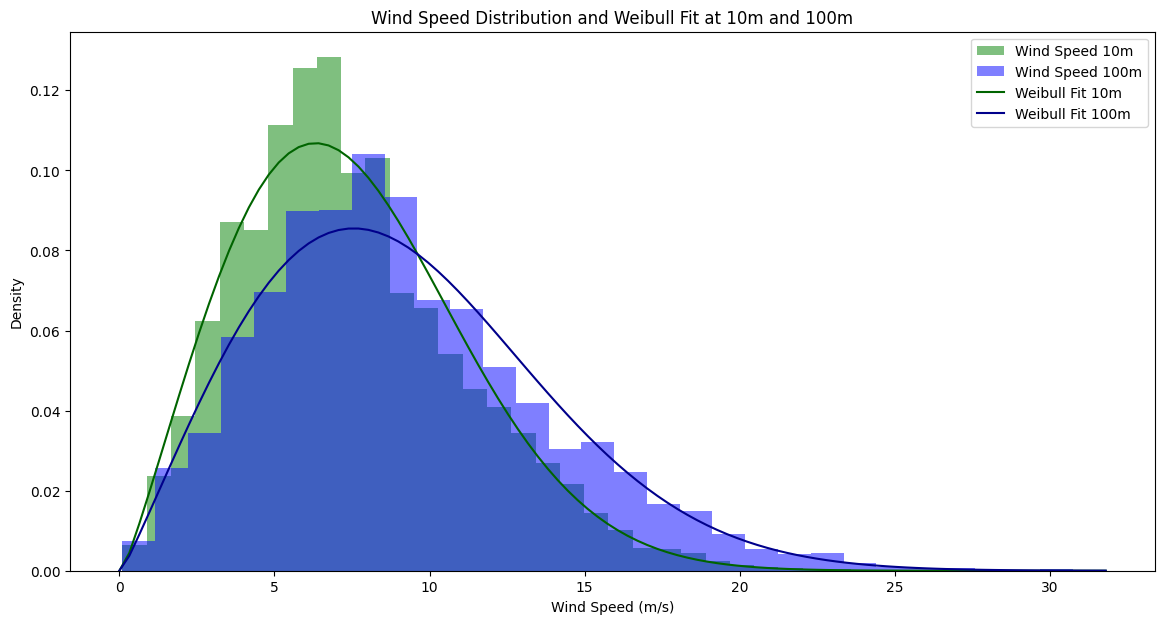

Weibull distribution parameters for 10m: (2.1336598205486617, 0.08481626477708204, 8.390459493756358)
Weibull distribution parameters for 100m: (2.074630346349357, 0.07067243409023909, 10.27771679343777)


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

# Read the dataset
data = pd.read_csv('Ouessant.csv')

# Define the related features: wind speed and direction at 10m and 100m heights, and the period end time
related_features = ['period_end', 'period', 'wind_speed_10m', 'wind_speed_100m', 'wind_direction_100m', 'wind_direction_10m']

# Step 1: Delete all non-wind-related and time-related features from the dataset
wind_data = data[related_features]

# Step 2: Extract a sub-dataset corresponding to exactly one year
# Convert the period_end column to datetime format
wind_data['period_end'] = pd.to_datetime(wind_data['period_end'])
# Define the start and end dates for one year of data
start_date = wind_data['period_end'].min()
end_date = start_date + pd.DateOffset(years=1)
# Create a subset of data for one year
one_year_data = wind_data[(wind_data['period_end'] >= start_date) & (wind_data['period_end'] < end_date)].copy()

# Step 3: Plot the wind direction as a function of time spanning the whole year
plt.figure(figsize=(14, 7))
plt.plot(one_year_data['period_end'], one_year_data['wind_direction_100m'], label='Wind Direction 100m', color='orange')
plt.plot(one_year_data['period_end'], one_year_data['wind_direction_10m'], label='Wind Direction 10m', color='green')
plt.xlabel('Time')
plt.ylabel('Wind Direction (degrees)')
plt.title('Wind Direction at 10m and 100m Over One Year')
plt.legend()
plt.show()

# Plot the wind speeds as a function of time spanning the whole year
plt.figure(figsize=(14, 7))
plt.plot(one_year_data['period_end'], one_year_data['wind_speed_100m'], label='Wind Speed 100m', color='blue')
plt.plot(one_year_data['period_end'], one_year_data['wind_speed_10m'], label='Wind Speed 10m', color='green')
plt.xlabel('Time')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed at 10m and 100m Over One Year')
plt.legend()
plt.show()

# Step 4: Calculate the number of hours during which the wind was not blowing (for the one-year subset)
# Count the number of rows where wind speed at both 10m and 100m is zero
no_wind_hours = one_year_data[(one_year_data['wind_speed_100m'] == 0) & (one_year_data['wind_speed_10m'] == 0)].shape[0]
print(f'Number of hours during which the wind was not blowing: {no_wind_hours}')

# Step 5: Plot the monthly-averaged wind-related features as a function of the number of the month
# Add a column for the month extracted from the period_end
one_year_data['month'] = one_year_data['period_end'].dt.month
# Define the columns of interest for averaging
numeric_cols = ['wind_direction_100m', 'wind_direction_10m', 'wind_speed_100m', 'wind_speed_10m']
# Group by month and calculate the mean for each numeric column
monthly_avg = one_year_data.groupby('month')[numeric_cols].mean()

# Plot the monthly average wind direction
plt.figure(figsize=(14, 7))
plt.plot(monthly_avg.index, monthly_avg['wind_direction_100m'], label='Avg Wind Direction 100m', color='orange')
plt.plot(monthly_avg.index, monthly_avg['wind_direction_10m'], label='Avg Wind Direction 10m', color='green')
plt.xlabel('Month')
plt.ylabel('Wind Direction (degrees)')
plt.title('Monthly-Averaged Wind Direction at 100m and 10m')
plt.legend()
plt.show()

# Plot the monthly average wind speed
plt.figure(figsize=(14, 7))
plt.plot(monthly_avg.index, monthly_avg['wind_speed_100m'], label='Avg Wind Speed 100m', color='blue')
plt.plot(monthly_avg.index, monthly_avg['wind_speed_10m'], label='Avg Wind Speed 10m', color='green')
plt.xlabel('Month')
plt.ylabel('Wind Speed (m/s)')
plt.title('Monthly-Averaged Wind Speed at 10m and 100m')
plt.legend()
plt.show()

# Step 6: Plot the wind speed distribution at 10m and 100m above the ground
# Fit Weibull distribution to wind speed data
params_10m = weibull_min.fit(one_year_data['wind_speed_10m'][one_year_data['wind_speed_10m'] > 0])
params_100m = weibull_min.fit(one_year_data['wind_speed_100m'][one_year_data['wind_speed_100m'] > 0])

# Generate the Weibull distribution
x = np.linspace(0, one_year_data[['wind_speed_10m', 'wind_speed_100m']].max().max(), 100)
weibull_10m = weibull_min.pdf(x, *params_10m)
weibull_100m = weibull_min.pdf(x, *params_100m)

# Plot the wind speed distribution and the fitted Weibull distribution
plt.figure(figsize=(14, 7))
plt.hist(one_year_data['wind_speed_10m'], bins=30, alpha=0.5, label='Wind Speed 10m', density=True, color='green')
plt.hist(one_year_data['wind_speed_100m'], bins=30, alpha=0.5, label='Wind Speed 100m', density=True, color='blue')
plt.plot(x, weibull_10m, label='Weibull Fit 10m', color='darkgreen')
plt.plot(x, weibull_100m, label='Weibull Fit 100m', color='darkblue')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Density')
plt.title('Wind Speed Distribution and Weibull Fit at 10m and 100m')
plt.legend()
plt.show()

print(f'Weibull distribution parameters for 10m: {params_10m}')
print(f'Weibull distribution parameters for 100m: {params_100m}')

# Explanation of the effect of wind direction
# Wind direction affects the efficiency of a wind turbine. Turbines are designed to face the prevailing wind direction to capture the maximum amount of wind energy. 
# If the wind direction varies significantly, turbines must have mechanisms to rotate and face the wind, which can add to maintenance and operational complexity.
# When installing a wind turbine, it is crucial to analyze the wind direction data to determine the most common wind directions and ensure that the turbines can efficiently capture the wind from those directions.
# Proper positioning and orientation based on wind direction data can significantly enhance energy production and reduce wear and tear on the turbine components.

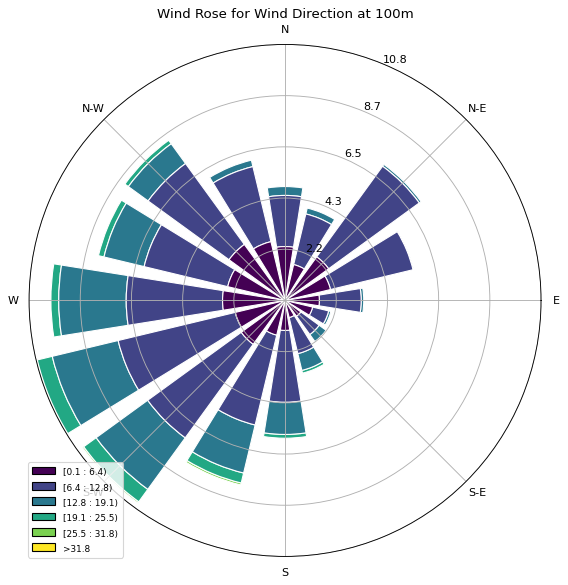

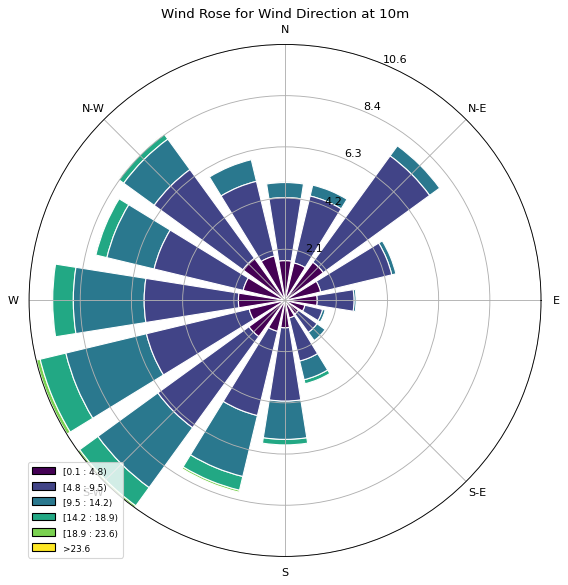

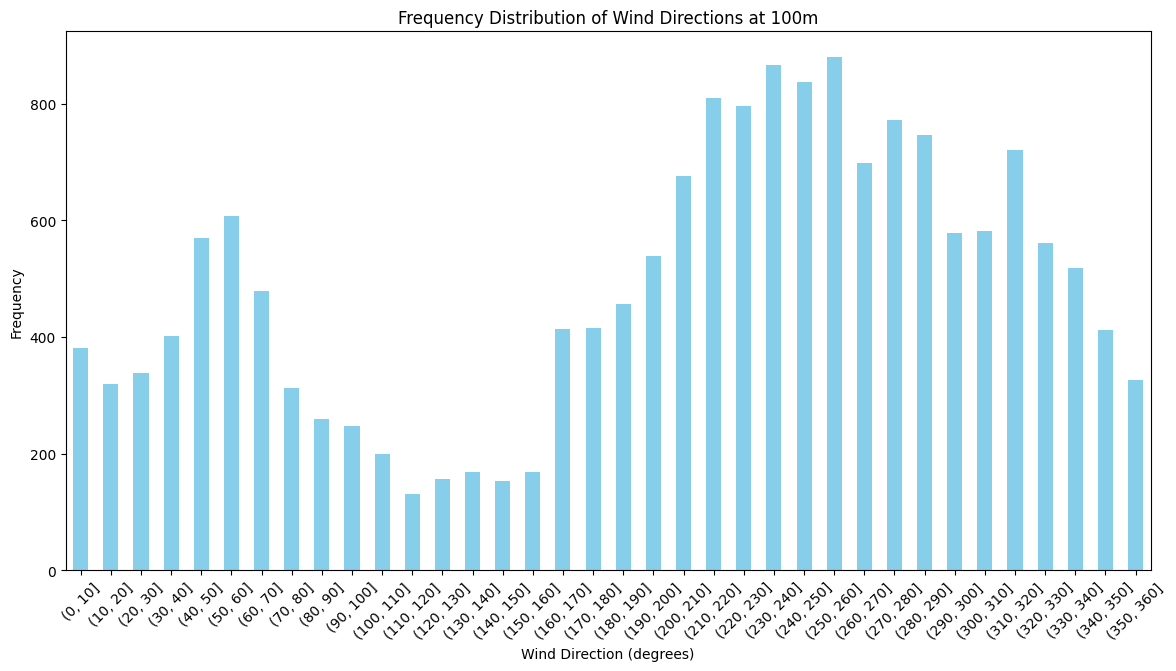

Average Wind Direction at 100m: 270.64 degrees


In [39]:

from windrose import WindroseAxes

# This function creates a wind rose plot for a given wind direction and speed data
# Inputs:
#   - direction (numpy array): Array containing wind direction values (degrees)
#   - speed (numpy array): Array containing wind speed values (corresponding to directions)
#   - title (string): Title for the wind rose plot
# Outputs:
#   - None (the function generates a plot and displays it)
def plot_wind_rose(direction, speed, title):
    ax = WindroseAxes.from_ax()  # Create wind rose axes from existing matplotlib axes
    ax.bar(direction, speed, normed=True, opening=0.8, edgecolor='white')  # Plot wind rose bars with normalization and white edges
    ax.set_legend()  # Add legend to the plot
    plt.title(title)  # Set plot title
    plt.show()  # Display the plot

# Plot the wind rose for wind direction at 100m
plot_wind_rose(one_year_data['wind_direction_100m'], one_year_data['wind_speed_100m'], 'Wind Rose for Wind Direction at 100m')

# Plot the wind rose for wind direction at 10m
plot_wind_rose(one_year_data['wind_direction_10m'], one_year_data['wind_speed_10m'], 'Wind Rose for Wind Direction at 10m')

# Calculate the frequency distribution of wind directions
wind_direction_bins = np.arange(0, 361, 10)  # 10-degree bins
one_year_data['wind_direction_100m_binned'] = pd.cut(one_year_data['wind_direction_100m'], bins=wind_direction_bins)
wind_direction_distribution = one_year_data['wind_direction_100m_binned'].value_counts().sort_index()

# Plot the distribution of wind directions
plt.figure(figsize=(14, 7))
wind_direction_distribution.plot(kind='bar', color='skyblue')
plt.xlabel('Wind Direction (degrees)')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Wind Directions at 100m')
plt.xticks(rotation=45)
plt.show()

# Calculate the vector average of wind directions
wind_direction_radians = np.deg2rad(one_year_data['wind_direction_100m'])
mean_sin = np.mean(np.sin(wind_direction_radians))
mean_cos = np.mean(np.cos(wind_direction_radians))
average_wind_direction = np.rad2deg(np.arctan2(mean_sin, mean_cos))
if average_wind_direction < 0:
    average_wind_direction += 360

print(f'Average Wind Direction at 100m: {average_wind_direction:.2f} degrees')


#Explanation of windrose plots
#We can see that the majority of the wind at both 10m and 100m heights comes from the west and northwest directions.
#This allows us to position our wind turbine to face these directions to capture the maximum amount of wind energy.
#They can even default to facing these directions so as to capture the most wind on average.

Alstom ECO122:
  Operating Hours: 8760.0 hours
  Total Power Production: 15303681.64 kWh/year
  Capacity Factor: 64.70%
Enercon E-33:
  Operating Hours: 8760.0 hours
  Total Power Production: 1263983.20 kWh/year
  Capacity Factor: 48.10%
Aventa AV-7:
  Operating Hours: 8760.0 hours
  Total Power Production: 37886.37 kWh/year
  Capacity Factor: 69.76%


/var/folders/bn/67qzjvps6cz42p_ym850l74r0000gn/T/ipykernel_39225/1577028370.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['period_end'] = pd.to_datetime(data['period_end']).dt.tz_localize(None)


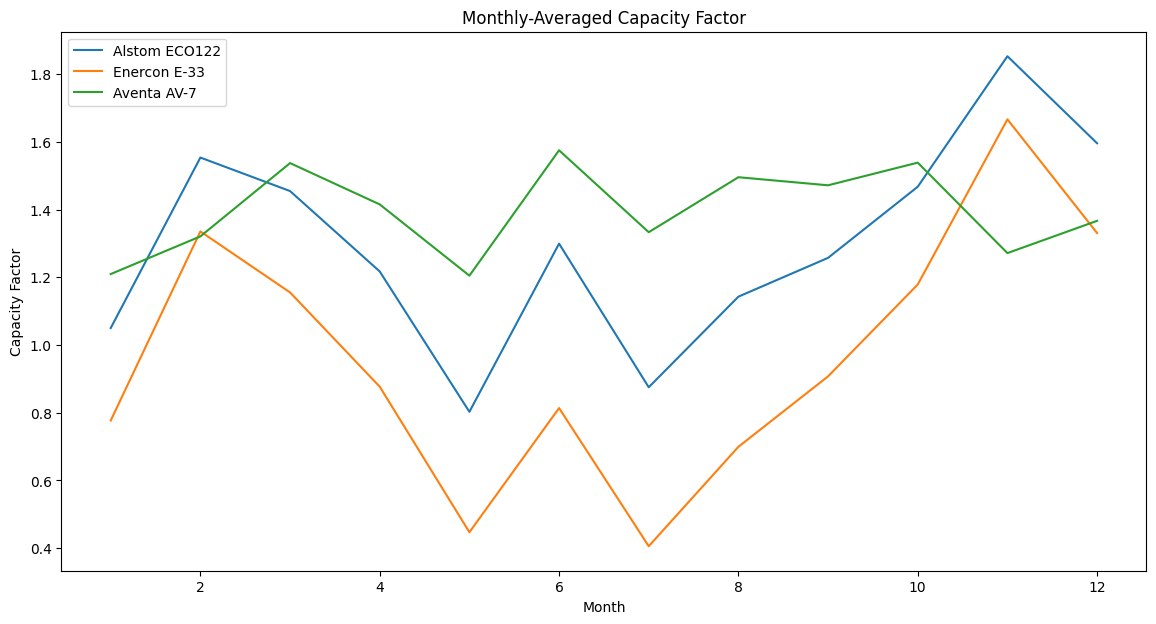

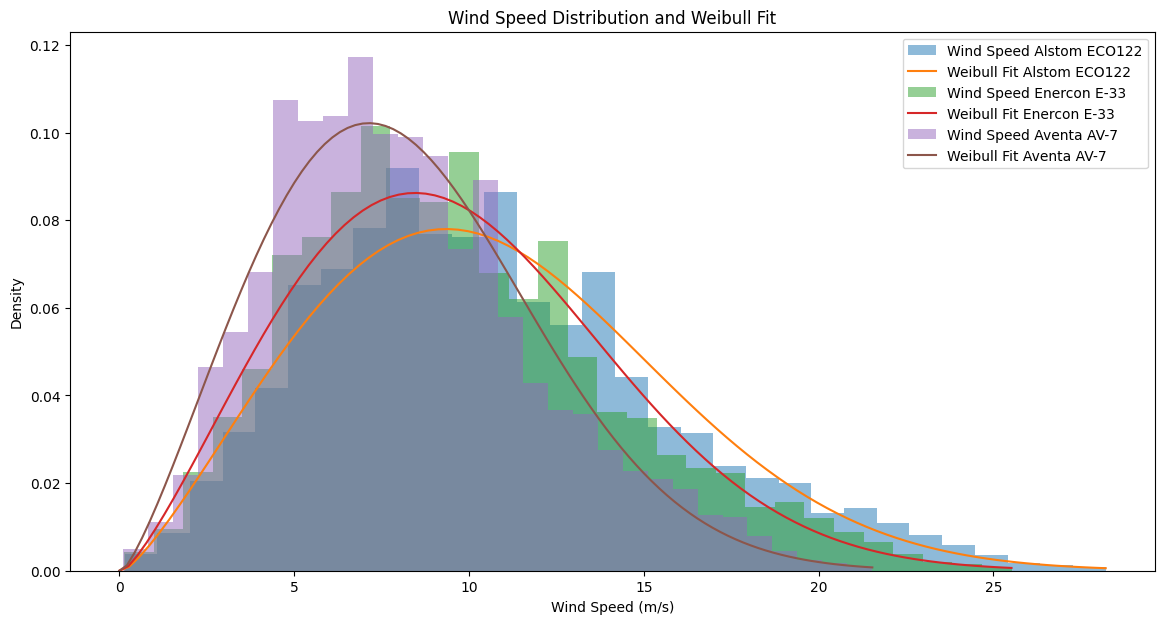

Year: 2020
Alstom ECO122:
  Operating Hours: 8784.0 hours
  Total Power Production: 16556168.02 kWh/year
  Capacity Factor: 69.81%
Enercon E-33:
  Operating Hours: 8784.0 hours
  Total Power Production: 1468570.41 kWh/year
  Capacity Factor: 55.73%
Aventa AV-7:
  Operating Hours: 8784.0 hours
  Total Power Production: 36364.16 kWh/year
  Capacity Factor: 66.77%


Year: 2021
Alstom ECO122:
  Operating Hours: 8760.0 hours
  Total Power Production: 15178714.85 kWh/year
  Capacity Factor: 64.18%
Enercon E-33:
  Operating Hours: 8760.0 hours
  Total Power Production: 1281758.39 kWh/year
  Capacity Factor: 48.77%
Aventa AV-7:
  Operating Hours: 8760.0 hours
  Total Power Production: 36873.31 kWh/year
  Capacity Factor: 67.89%


Year: 2022
Alstom ECO122:
  Operating Hours: 8760.0 hours
  Total Power Production: 15303681.64 kWh/year
  Capacity Factor: 64.70%
Enercon E-33:
  Operating Hours: 8760.0 hours
  Total Power Production: 1263983.20 kWh/year
  Capacity Factor: 48.10%
Aventa AV-7:
  Oper

/var/folders/bn/67qzjvps6cz42p_ym850l74r0000gn/T/ipykernel_39225/1577028370.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['period_end'] = pd.to_datetime(data['period_end']).dt.tz_localize(None)
/var/folders/bn/67qzjvps6cz42p_ym850l74r0000gn/T/ipykernel_39225/1577028370.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['period_end'] = pd.to_datetime(data['period_end']).dt.tz_localize(None)
/var/folders/bn/67qzjvps6cz42p_ym850l74r0000gn/T/ipykernel_39225/1577028370.py:32: SettingWithCopyWa

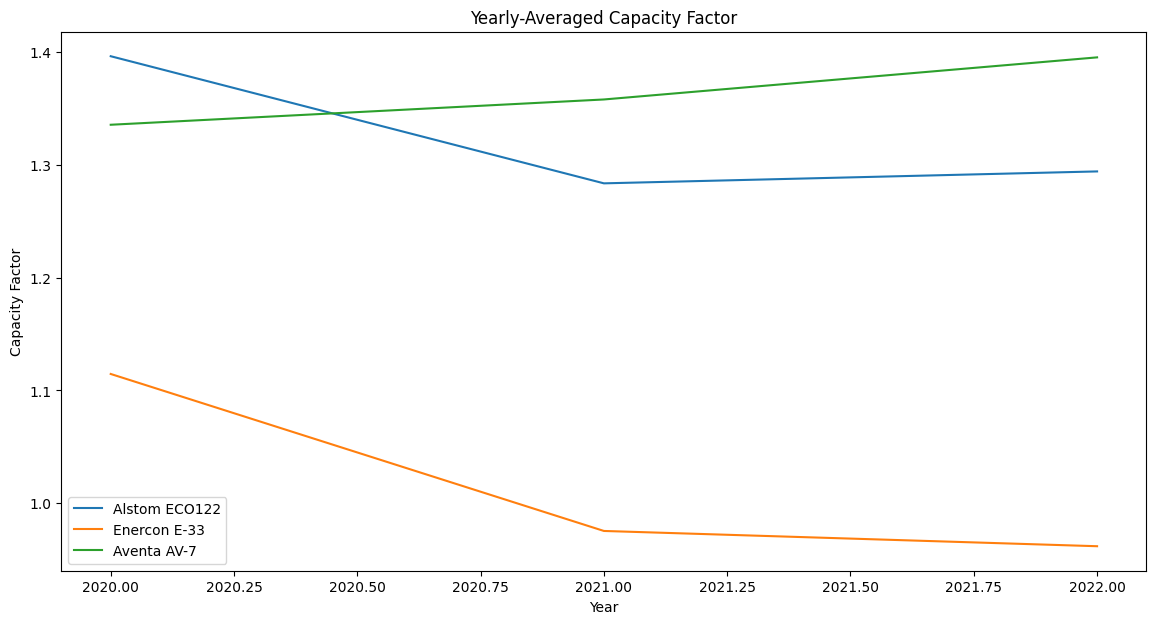

In [46]:
turbine_data = {
    'Alstom ECO122': {'hub_height': 90, 'rated_power': 2700, 'cut_in_wind_speed': 3, 'rated_wind_speed': 10, 'cut_out_wind_speed': 34},  # m, kW, m/s
    'Enercon E-33': {'hub_height': 47, 'rated_power': 300,  'cut_in_wind_speed': 3, 'rated_wind_speed': 11.5, 'cut_out_wind_speed': 25},     # m, kW, m/s
    'Aventa AV-7': {'hub_height': 18, 'rated_power': 6.2, 'cut_in_wind_speed': 2, 'rated_wind_speed': 6, 'cut_out_wind_speed': 14}        # m, kW, m/s
}

# Function to calculate wind speed at hub height using the wind log profile formula
# Inputs:
#   - wind_speed_10m (float): Wind speed at 10m height (m/s)
#   - hub_height (float): Height of the wind turbine hub (m)
#   - z0 (float, optional): Roughness length of the terrain (default: 0.1 for open terrain)
# Outputs:
#   - wind_speed_at_height (float): Wind speed at hub height (m/s)

# z0 is the roughness length, typically 0.1 for open terrain Coastal regions 
#like Ouessant can often be characterized by relatively open areas with sparse vegetation and some small bushes or agricultural fields, 
#aligning well with a 𝑧0 of 0.1. 
def calculate_wind_speed_at_height(wind_speed_10m, hub_height, z0=0.1):
    return wind_speed_10m * (np.log(hub_height / z0) / np.log(10 / z0))

# Function to define a power curve for a wind turbine model
# Inputs:
#   - speed (numpy array): Array of wind speeds (m/s)
#   - cut_in_speed (float): Wind speed at which power generation begins (m/s)
#   - rated_speed (float): Wind speed at which rated power is produced (m/s)
#   - cut_out_speed (float): Wind speed at which power generation stops (m/s)
#   - rated_power (float): Rated power output of the turbine (kW)
# Outputs:
#   - power_output (numpy array): Array of power output values at corresponding wind speeds (kW)
def power_curve(speed, cut_in_speed, rated_speed, cut_out_speed, rated_power):
    power_output = np.zeros_like(speed)
    
    # Below cut-in speed: No power
    between_cut_in_rated_mask = (speed >= cut_in_speed) & (speed < rated_speed)

    #Assuming cubic over power curve as the power contained in the wind is
    #P= 1/2 * p * A * v^3 
    #where p is the air density, A is the area of the rotor and v is the wind speed
    power_output[between_cut_in_rated_mask] = rated_power * ((speed[between_cut_in_rated_mask] - cut_in_speed) / (rated_speed - cut_in_speed))**3
    
    # Between rated and cut-out speed: Constant power
    between_rated_cut_out_mask = (speed >= rated_speed) & (speed < cut_out_speed)
    power_output[between_rated_cut_out_mask] = rated_power
    
    # Above cut-out speed: No power (already zero from initialization)
    
    return power_output

# Function to analyze wind turbine data for a given year
# Inputs:
#   - data (pandas DataFrame): DataFrame containing wind data
#   - year (int): Year for which analysis is performed
#   - z0 (float, optional): Roughness length of the terrain (default: 0.1 for open terrain)
# Outputs:
#   - one_year_data (pandas DataFrame): DataFrame containing wind data for the specified year with additional columns for wind speed at hub height and power output for each turbine
def analyze_wind_turbine(data, year, z0=0.1):
    # Define the start and end dates for the given year
    start_date = pd.to_datetime(f'{year}-01-01').tz_localize(None)
    end_date = (start_date + pd.DateOffset(years=1)).tz_localize(None)
    data['period_end'] = pd.to_datetime(data['period_end']).dt.tz_localize(None)
    # Extract one year of data
    one_year_data = data[(data['period_end'] >= start_date) & (data['period_end'] < end_date)].copy()
    
    # Calculate wind speed at hub height and power for each turbine
    for turbine in turbine_data:
        hub_height = turbine_data[turbine]['hub_height']
        one_year_data[f'wind_speed_{turbine}'] = calculate_wind_speed_at_height(one_year_data['wind_speed_10m'], hub_height, z0)
        one_year_data[f'power_{turbine}'] = power_curve(one_year_data[f'wind_speed_{turbine}'], 
                                                        turbine_data[turbine]['cut_in_wind_speed'], 
                                                        turbine_data[turbine]['rated_wind_speed'], 
                                                        turbine_data[turbine]['cut_out_wind_speed'], 
                                                        turbine_data[turbine]['rated_power'])
        
        one_year_data[f'capacity_factor_{turbine}'] = one_year_data[f'power_{turbine}'] / (turbine_data[turbine]['rated_power'] * 0.5)
    
    return one_year_data

# Function to calculate statistics for a turbine in a year
# Inputs:
#   - one_year_data (pandas DataFrame): DataFrame containing wind data for the year
#   - turbine (str): Name of the turbine model
# Outputs:
#   - operating_hours (float): Number of hours of data (assuming data is half-hourly)
#   - total_power (float): Total power production by the turbine (kWh)
#   - capacity_factor (float): Capacity factor of the turbine
def calculate_statistics(one_year_data, turbine):
    operating_hours = len(one_year_data) / 2  # Assuming data is half-hourly
    total_power = one_year_data[f'power_{turbine}'].sum() / 2  # kWh
    capacity_factor = total_power / (turbine_data[turbine]['rated_power'] * operating_hours) # kWh / (kW * hours) (divide power produced by theoretical maximum)
    return operating_hours, total_power, capacity_factor

# Function to plot capacity factor by month for a year
# Inputs:
#   - one_year_data (pandas DataFrame): DataFrame containing wind data for the year
# Outputs:
#   - None (the function generates a plot and displays it)
def plot_monthly_capacity_factor(one_year_data):
    one_year_data['month'] = one_year_data['period_end'].dt.month
    monthly_avg_capacity_factor = one_year_data.groupby('month')[['capacity_factor_Alstom ECO122', 'capacity_factor_Enercon E-33', 'capacity_factor_Aventa AV-7']].mean()

    plt.figure(figsize=(14, 7))
    plt.plot(monthly_avg_capacity_factor.index, monthly_avg_capacity_factor['capacity_factor_Alstom ECO122'], label='Alstom ECO122')
    plt.plot(monthly_avg_capacity_factor.index, monthly_avg_capacity_factor['capacity_factor_Enercon E-33'], label='Enercon E-33')
    plt.plot(monthly_avg_capacity_factor.index, monthly_avg_capacity_factor['capacity_factor_Aventa AV-7'], label='Aventa AV-7')
    plt.xlabel('Month')
    plt.ylabel('Capacity Factor')
    plt.title('Monthly-Averaged Capacity Factor')
    plt.legend()
    plt.show()

# Function to plot Weibull distributions and histograms for wind speeds of each turbine
# Inputs:
#   - one_year_data (pandas DataFrame): DataFrame containing wind data for the year
# Outputs:
#   - None (the function generates a plot and displays it)
def plot_weibull_distributions(one_year_data):
    plt.figure(figsize=(14, 7))
    
    for turbine in turbine_data:
        params = weibull_min.fit(one_year_data[f'wind_speed_{turbine}'][one_year_data[f'wind_speed_{turbine}'] > 0])
        x = np.linspace(0, one_year_data[f'wind_speed_{turbine}'].max(), 100)
        weibull_pdf = weibull_min.pdf(x, *params)
        
        plt.hist(one_year_data[f'wind_speed_{turbine}'], bins=30, alpha=0.5, label=f'Wind Speed {turbine}', density=True)
        plt.plot(x, weibull_pdf, label=f'Weibull Fit {turbine}')
    
    plt.xlabel('Wind Speed (m/s)')
    plt.ylabel('Density')
    plt.title('Wind Speed Distribution and Weibull Fit')
    plt.legend()
    plt.show()

# Function to analyze wind turbine data for multiple years
# Inputs:
#   - data (pandas DataFrame): DataFrame containing wind data
#   - start_year (int): Starting year for analysis
#   - end_year (int): Ending year for analysis
# Outputs:
#   - results (dict): Dictionary containing wind data for each analyzed year
def analyze_multiple_years(data, start_year, end_year):
    results = {}
    for year in range(start_year, end_year + 1):
        result = analyze_wind_turbine(data, year)
        results[year] = result
        # Calculate and print statistics for each year
        print(f"Year: {year}")
        for turbine in turbine_data:
            operating_hours, total_power, capacity_factor = calculate_statistics(result, turbine)
            print(f"{turbine}:")
            print(f"  Operating Hours: {operating_hours} hours")
            print(f"  Total Power Production: {total_power:.2f} kWh/year")
            print(f"  Capacity Factor: {capacity_factor:.2%}")
        print("\n")
    return results

# Function to plot capacity factor by year for multiple years
# Inputs:
#   - results (dict): Dictionary containing wind data for each analyzed year
# Outputs:
#   - None (the function generates a plot and displays it)
def plot_capacity_factor_yearly(results):
    yearly_capacity_factors = {}
    for year, result in results.items():
        yearly_capacity_factors[year] = {
            turbine: result[f'capacity_factor_{turbine}'].mean()
            for turbine in turbine_data
        }
    yearly_capacity_factors_df = pd.DataFrame(yearly_capacity_factors).T
    
    plt.figure(figsize=(14, 7))
    for turbine in turbine_data:
        plt.plot(yearly_capacity_factors_df.index, yearly_capacity_factors_df[turbine], label=turbine)
    plt.xlabel('Year')
    plt.ylabel('Capacity Factor')
    plt.title('Yearly-Averaged Capacity Factor')
    plt.legend()
    plt.show()

# Analyze wind turbine data for the year 2022
result_2022 = analyze_wind_turbine(wind_data, 2022)

# Power curve accounts for when zero power is being produced


for turbine in turbine_data:
    operating_hours, total_power, capacity_factor = calculate_statistics(result_2022, turbine)
    print(f"{turbine}:")
    print(f"  Operating Hours: {operating_hours} hours")
    print(f"  Total Power Production: {total_power:.2f} kWh/year")
    print(f"  Capacity Factor: {capacity_factor:.2%}")

# Step 4: Plot capacity factor by month for 2022
plot_monthly_capacity_factor(result_2022)

# Step 5: Plot Weibull distributions for 2022
plot_weibull_distributions(result_2022)

# Step 6: Analyze wind turbine data for multiple years (2020-2022)
results_multiple_years = analyze_multiple_years(wind_data, 2020, 2022)

# Step 7: Plot capacity factor by year for multiple years
plot_capacity_factor_yearly(results_multiple_years)

In [48]:
# Step 8: Analysis and Recommendations
# Average electricity consumption in France per person is 2,223 kWh per year

# Function to calculate the number of turbines needed to power a town
def calculate_turbines_needed(population, turbine_power):
    total_energy_needed = population * 2223  # kWh/year
    turbines_needed = np.ceil(total_energy_needed / turbine_power)
    return turbines_needed

# Population of the Charmonix town
population = 8800

# Calculate the number of turbines needed for each turbine model
for turbine in turbine_data:
    _, total_power, _ = calculate_statistics(result_2022, turbine)
    turbines_needed = calculate_turbines_needed(population, total_power)
    print(f"{turbine}: {turbines_needed} turbines needed to power a town of {population} people")

#Typical wind turbine costs between 700,000 to 3mil dollars, these are rough estimates given the rated power and sizes of the turbines
costs = {
    'Alstom ECO122': 3_000_000,  # USD
    'Enercon E-33': 1_000_000,   # USD
    'Aventa AV-7': 100_000       # USD
}

# Calculate and print cost analysis for each turbine model
for turbine in turbine_data:
    _, total_power, _ = calculate_statistics(result_2022, turbine)
    turbines_needed = calculate_turbines_needed(population, total_power)
    total_cost = turbines_needed * costs[turbine]
    print(f"{turbine}: Total cost to power a town of {population} people is ${total_cost:.2f}")

# Assume a simple storage model where we need to cover 24 hours without wind
# Example assumption: average daily consumption per person is 6.1 kWh (2223 kWh/year / 365 days)
daily_consumption_per_person = 2223 / 365  # kWh/day
total_daily_consumption = population * daily_consumption_per_person  # kWh/day

# Assuming a worst-case scenario where we need to store one day's worth of energy
storage_capacity_needed = total_daily_consumption  # kWh

print(f"Storage capacity needed to cover one day without wind: {storage_capacity_needed:.2f} kWh")


#Analysis
#Since even though Aventa has a higher capacity factor given our wind speeds data for Ouessant, I would choose AlstomECO122, and two of them
#to power a town of 10k people in charmonix, these are much more powerful and the net cost for both is much cheaper compared to Enercon and Aventa
#The storage capacity needed is a lot on a daily basis around 53000 kWh and would require a large battery bank
#I believe that a mix of renewables and fossils would work best especially since Charmonix has extremely high peak energy loads during
#Skiing season, creating larger energy demands from it

Alstom ECO122: 2.0 turbines needed to power a town of 8800 people
Enercon E-33: 16.0 turbines needed to power a town of 8800 people
Aventa AV-7: 517.0 turbines needed to power a town of 8800 people
Alstom ECO122: Total cost to power a town of 8800 people is $6000000.00
Enercon E-33: Total cost to power a town of 8800 people is $16000000.00
Aventa AV-7: Total cost to power a town of 8800 people is $51700000.00
Storage capacity needed to cover one day without wind: 53595.62 kWh
